## Why the Digital Option Example Exposes MLMC’s “Blind-Sampling” Failure

1. **Payoff Discontinuity → Poor Coupling**  
   Define the level-ℓ increment as  
   $$
   \Delta P_\ell \;=\; P_\ell - P_{\ell-1}\,.
   $$  
   For a digital payoff  
   $$
   P(S_T)=\mathbf{1}_{\{S_T>K\}},
   $$  
   almost every fine/coarse pair produces the same 0 → 0 or 1 → 1, until a rare path crosses the strike. Hence  $\Delta P_\ell$ is almost always zero, and its variance is tiny except on boundary paths.

2. **Flat & Clamped Pilot Variance Estimates**  
   In the pilot phase we draw \(N_0=1024\) coupled samples at each level and compute the **sample variance** of the single‐path increments:
   $$
   V_\ell
   \;\approx\;
   \mathrm{Var}\bigl[\Delta P_\ell\bigr]
   \;
   $$
   Because  $\Delta P_\ell $ is nearly always zero, we get  $\;V_0\approx V_1\approx V_2\; $,  a flat, uninformative profile.

3. **Blind Allocation Sees No Signal**  
   The MLMC allocation rule  
   $$
   N_\ell \;\propto\;\sqrt{\frac{V_\ell}{C_\ell}}
   $$
   then “sees” almost identical  $V_\ell $ at every level and, despite the fact that cost  $C_\ell $ grows like  $2^\ell $, ends up assigning roughly the same  $N_\ell $ everywhere.

4. **Wasted Computation on Coarse Levels**  
   Coarse levels ( $\ell $ small) are cheap per sample but contribute virtually **no information** (since  $\Delta P_\ell\approx 0 $ almost always). Standard MLMC still invests thousands of samples there, purely based on its blind variance–cost ratio.

   Simply refining levels makes non-zero corrections even rarer ( $\Pr(\Delta P_\ell\neq0)=O(\sqrt{h_\ell})$), so MLMC wastes costly fine‐level samples on zeros. You need smoothing or targeted stratification to catch the rare boundary crossings.
5. **Where AI/ML Can Help**  
   This failure mode pinpoints exactly **why** and **where** to intervene with learning:  
   - **Detect** the rare “boundary” paths that produce nonzero  $\Delta P_\ell $.  
   - **Cluster** or score those paths by their feature‐based impact.  
   - **Reallocate** sampling effort away from the mass of zero‐difference paths toward the few that matter.


In [23]:
# Imports & Parameters
import sys, os, time, math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# allow import of your local mlmc package
sys.path.append(os.path.abspath('..'))
from mlmc import MLMC, WeakConvergenceError
from mlmc.bs_model import make_bs_level_fn

# Black–Scholes / MLMC parameters
S0, K = 100.0, 100.0
r, σ  = 0.05, 0.20
T     = 1.0
disc  = math.exp(-r * T)

# Target tolerances for demonstration
EPS = [0.1, 0.05, 0.025]


In [24]:
# Digital payoff & MLMC setup
def digital_payoff(S, K):
    return (S > K).astype(float)

payoff_fn = lambda S: digital_payoff(S, K)
mlmc = MLMC(make_bs_level_fn(S0, r, σ, T, payoff_fn))


In [25]:
# Run MLMC only and collect per-level allocations
records = []

for eps in EPS:
    rec = {"epsilon": eps}
    try:
        t0 = time.perf_counter()
        price, Nl, Cl, total_cost = mlmc.estimate(eps)
        rec.update({
            "price": price,
            "time_s": time.perf_counter() - t0,
            "total_cost": total_cost,
            "N_per_level": Nl.copy()
        })
    except WeakConvergenceError as err:
        rec.update({
            "price": np.nan,
            "time_s": np.nan,
            "total_cost": np.nan,
            "N_per_level": None,
            "error": str(err)
        })
    records.append(rec)


Remark:
This example made us discover this issue
___
RuntimeWarning: divide by zero encountered in log2
  alpha = max(0.5, -np.linalg.lstsq(A, np.log2(ml[1:]), rcond=None)[0][0])
___
This is because V_l is almost always equal to zero, check the changes in mlmc.core.py. We solved b y adding a safety procedure.

In [26]:
# results
df = pd.DataFrame(records)
# expand N_per_level into separate columns
Nl_df = pd.DataFrame(df["N_per_level"].tolist(), index=df.index).add_prefix("N_l_")
out = pd.concat([df.drop(columns="N_per_level"), Nl_df], axis=1)
display(out)


,epsilon,price,time_s,total_cost,N_l_0,N_l_1,N_l_2
0,0.100,0.560148,0.001406,7168.0,1024,1024,1024
1,0.050,0.538782,0.000836,7168.0,1024,1024,1024
2,0.025,0.534138,0.000595,7168.0,1024,1024,1024


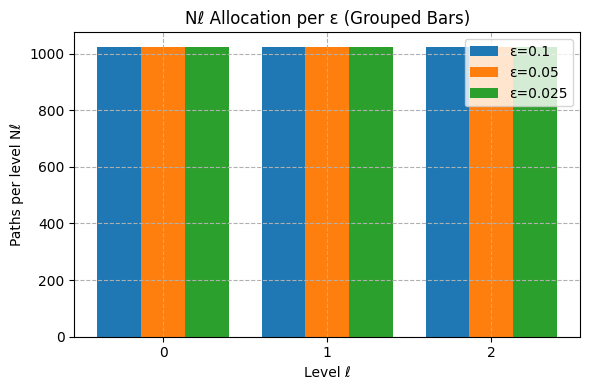

In [27]:
levels = np.arange(max(len(rec["N_per_level"]) for rec in records))
bar_width = 0.8 / len(records)
fig, ax = plt.subplots(figsize=(6, 4))
for i, rec in enumerate(records):
    Nl = rec["N_per_level"]
    ax.bar(levels + i*bar_width, Nl, width=bar_width, label=f"ε={rec['epsilon']}")
ax.set_xticks(levels + bar_width*(len(records)-1)/2)
ax.set_xticklabels(levels)
ax.set_xlabel("Level ℓ")
ax.set_ylabel("Paths per level Nℓ")
ax.set_title("Nℓ Allocation per ε (Grouped Bars)")
ax.legend()
ax.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


In [28]:
# Inspect Yₗ for levels 0 and 1 to compare payoff variance vs. increment variance
N_test = 100_000

for l_test in [0, 1, 2]:
    # simulate N_test coupled samples at level l_test
    sums, cost = mlmc._f(l_test, N_test)
    sumY, sumY2 = sums

    # empirical mean and variance of Yₗ
    meanY = sumY  / N_test
    varY  = sumY2 / N_test - meanY**2

    print(f"Level {l_test}: mean(Y_{l_test}) = {meanY:.3e}, var(Y_{l_test}) = {varY:.3e}")


Level 0: mean(Y_0) = 5.315e-01, var(Y_0) = 2.231e-01
Level 1: mean(Y_1) = 0.000e+00, var(Y_1) = 0.000e+00
Level 2: mean(Y_2) = 0.000e+00, var(Y_2) = 0.000e+00


In [29]:
# Imports & Parameters
import sys, os, time, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# allow imports from parent directory
sys.path.append(os.path.abspath(".."))

from mlmc import MLMC, C_MLMC, WeakConvergenceError
from mlmc.bs_model import make_bs_level_fn

# Black–Scholes & experiment setup
S0, K, r, σ, T = 100.0, 100.0, 0.05, 0.20, 1.0
disc = math.exp(-r*T)
EPS = [0.1, 0.05, 0.025]

# digital payoff
def digital_payoff(S, K):
    return (S > K).astype(float)

# feature extractor for C_MLMC: distance to strike on fine & coarse
def feature_fn(detail):
    S_f = detail["S_fine"]
    S_c = detail.get("S_coarse", S_f)
    return np.array([
        abs(S_f - S_c),                              # asset increment
        abs(S_f   - K),                              # fine dist
        abs(S_c   - K),                              # coarse dist
        int((S_f - K)*(S_c - K) < 0)                 # crossing indicator
    ])

# build level function with return_details
level_fn = make_bs_level_fn(S0, r, σ, T, lambda S: digital_payoff(S, K))

# instantiate both estimators
N0=1024
mlmc   = MLMC(level_fn,N0=N0)
cmlmc  = C_MLMC(level_fn, feature_fn, n_clusters=4, N0=N0)


In [30]:
# Run both MLMCs and collect results
records = []

for eps in EPS:
    rec = {"epsilon": eps}

    # -- standard MLMC --
    try:
        t0 = time.perf_counter()
        price_ml, Nl_ml, Cl_ml, cost_ml = mlmc.estimate(eps)
        rec.update({
            "price_ml": price_ml,
            "time_ml":  time.perf_counter() - t0,
            "cost_ml":  cost_ml,
            "Nl_ml":    Nl_ml.copy(),
        })
    except WeakConvergenceError:
        rec.update({
            "price_ml": np.nan,
            "time_ml":  np.nan,
            "cost_ml":  np.nan,
            "Nl_ml":    None,
        })

    # -- clustered MLMC --
    try:
        t1 = time.perf_counter()
        price_cl, Nl_cl, Cl_cl, cost_cl = cmlmc.estimate(eps)
        rec.update({
            "price_cl": price_cl,
            "time_cl":  time.perf_counter() - t1,
            "cost_cl":  cost_cl,
            "Nl_cl":    Nl_cl.copy(),
        })
    except WeakConvergenceError:
        rec.update({
            "price_cl": np.nan,
            "time_cl":  np.nan,
            "cost_cl":  np.nan,
            "Nl_cl":    None,
        })

    records.append(rec)

# convert to DataFrame
df = pd.DataFrame(records)
display(df)


,epsilon,price_ml,time_ml,cost_ml,Nl_ml,price_cl,time_cl,cost_cl,Nl_cl
0,0.100,0.542498,0.001871,7168.0,"[1024, 1024, 1024]",0.535067,0.030101,7168.0,"[1024, 1024, 1024]"
1,0.050,0.519275,0.001026,7168.0,"[1024, 1024, 1024]",0.532280,0.017665,7168.0,"[1024, 1024, 1024]"
2,0.025,0.539711,0.000766,7168.0,"[1024, 1024, 1024]",0.536871,0.037311,8933.0,"[1483, 1024, 1024]"


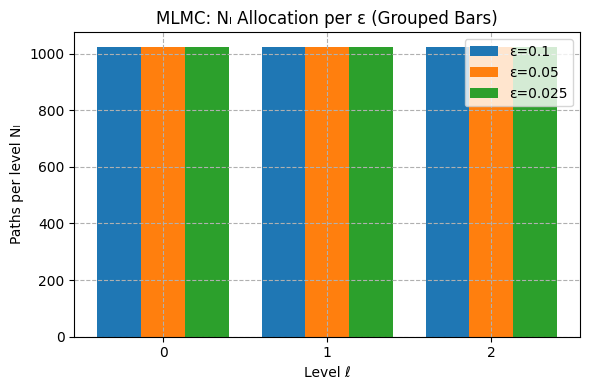

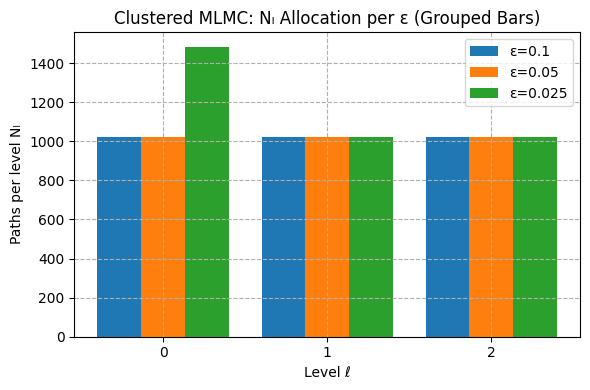

In [31]:
# Grouped bar chart of MLMC allocations across ε
levels = np.arange(max(len(rec["Nl_ml"]) for rec in records))
bar_width = 0.8 / len(records)

fig, ax = plt.subplots(figsize=(6, 4))
for i, rec in enumerate(records):
    Nl_ml = rec["Nl_ml"]
    ax.bar(levels + i*bar_width, Nl_ml, width=bar_width, label=f"ε={rec['epsilon']}")
ax.set_xticks(levels + bar_width*(len(records)-1)/2)
ax.set_xticklabels(levels)
ax.set_xlabel("Level ℓ")
ax.set_ylabel("Paths per level Nₗ")
ax.set_title("MLMC: Nₗ Allocation per ε (Grouped Bars)")
ax.legend()
ax.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# Grouped bar chart of Clustered‐MLMC allocations across ε
levels = np.arange(max(len(rec["Nl_cl"]) for rec in records))
bar_width = 0.8 / len(records)

fig, ax = plt.subplots(figsize=(6, 4))
for i, rec in enumerate(records):
    Nl_cl = rec["Nl_cl"]
    ax.bar(levels + i*bar_width, Nl_cl, width=bar_width, label=f"ε={rec['epsilon']}")
ax.set_xticks(levels + bar_width*(len(records)-1)/2)
ax.set_xticklabels(levels)
ax.set_xlabel("Level ℓ")
ax.set_ylabel("Paths per level Nₗ")
ax.set_title("Clustered MLMC: Nₗ Allocation per ε (Grouped Bars)")
ax.legend()
ax.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


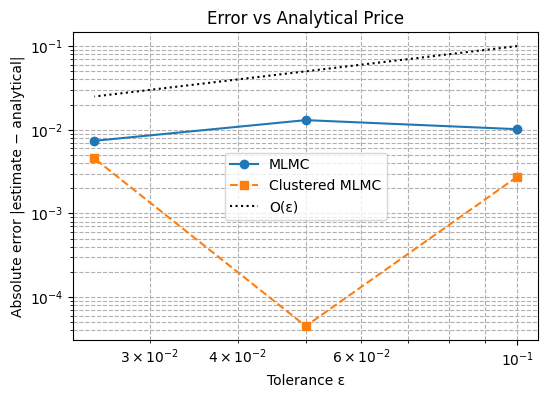

In [32]:
# Error vs Analytical ———
import math
import matplotlib.pyplot as plt

# 1) Analytical digital‐call price: exp(−rT)·N(d2)
def norm_cdf(x):
    return 0.5 * (1 + math.erf(x/math.sqrt(2)))

d2 = (math.log(S0/K) + (r - 0.5*σ**2)*T) / (σ*math.sqrt(T))
analytical = math.exp(-r*T) * norm_cdf(d2)

# 2) Extract errors
tols      = [rec["epsilon"]  for rec in records]
errors_ml = [abs(rec["price_ml"] - analytical) for rec in records]
errors_cl = [abs(rec["price_cl"] - analytical) for rec in records]

# 3) Plot on log–log
fig, ax = plt.subplots(figsize=(6,4))
ax.loglog(tols, errors_ml, 'o-', label='MLMC')
ax.loglog(tols, errors_cl, 's--', label='Clustered MLMC')
ax.loglog(tols, tols, 'k:', label='O(ε)')

ax.set_xlabel("Tolerance ε")
ax.set_ylabel("Absolute error |estimate − analytical|")
ax.set_title("Error vs Analytical Price")
ax.legend()
ax.grid(True, which="both", ls="--")
plt.show()


## Why Level 0 Dominates in the Digital Option Example

**Large time step ⇒ high jump probability**  
   At level 0, we use a single Euler step of size $h = T$, so the terminal price is  
   $$  
   S_T^{(h)} = S_0 \exp\bigl((r - \tfrac12\sigma^2)T + \sigma\sqrt{T}\,Z\bigr).  
   $$  
   Whether $S_T^{(h)} > K$ is then a Bernoulli event with variance $p(1 - p) \approx 0.25$, giving $Y_0 = P_0$ high variance.



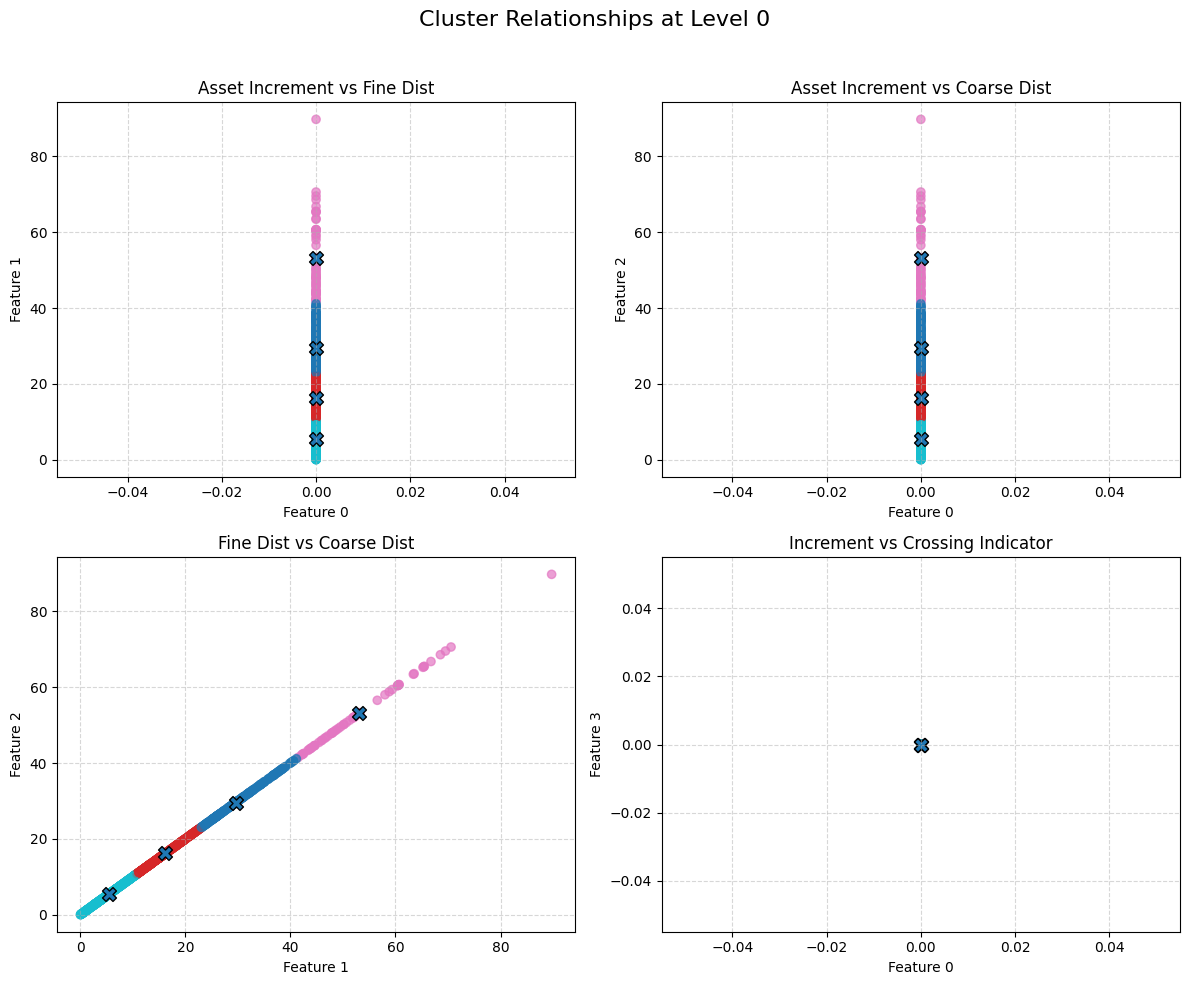

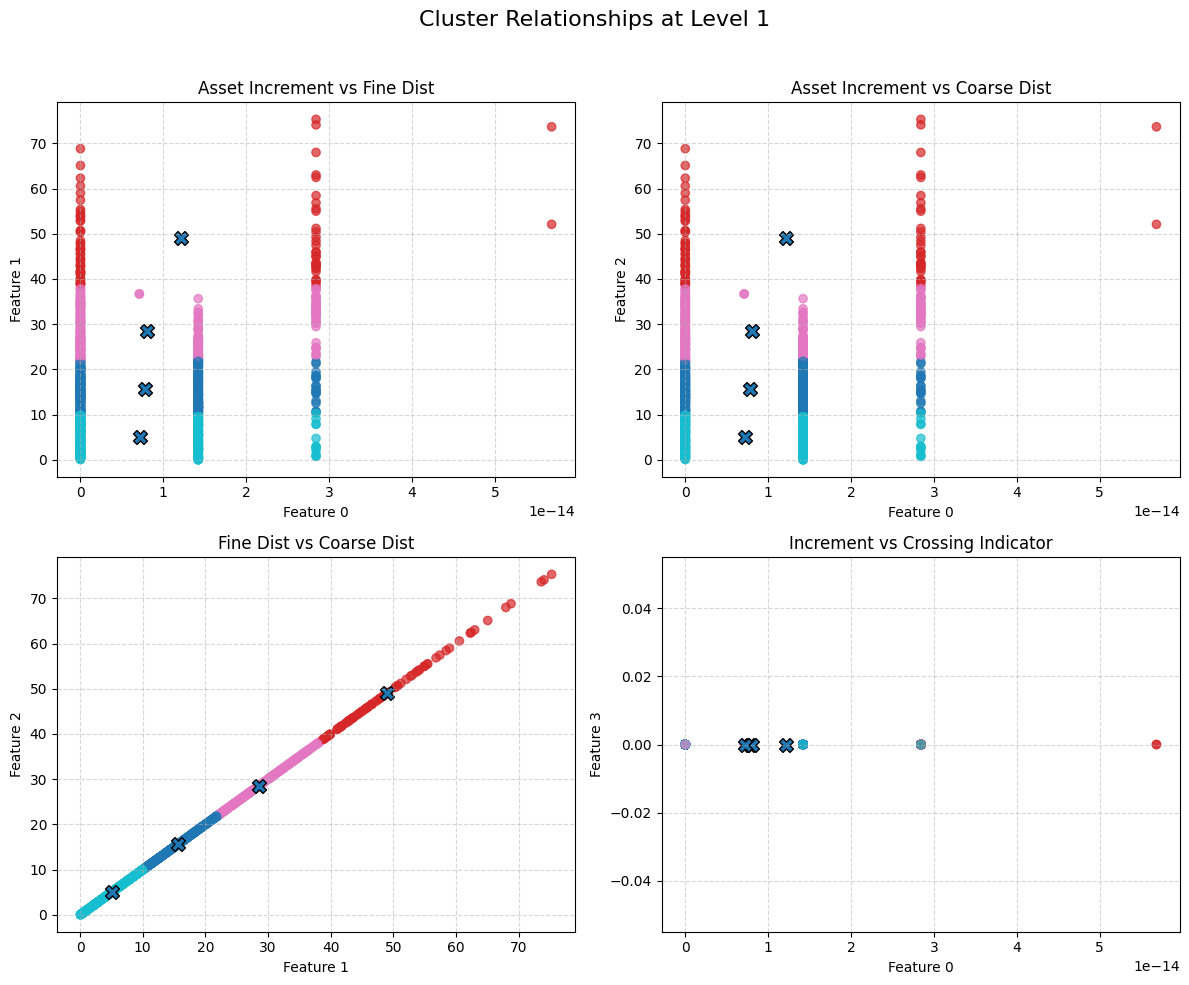

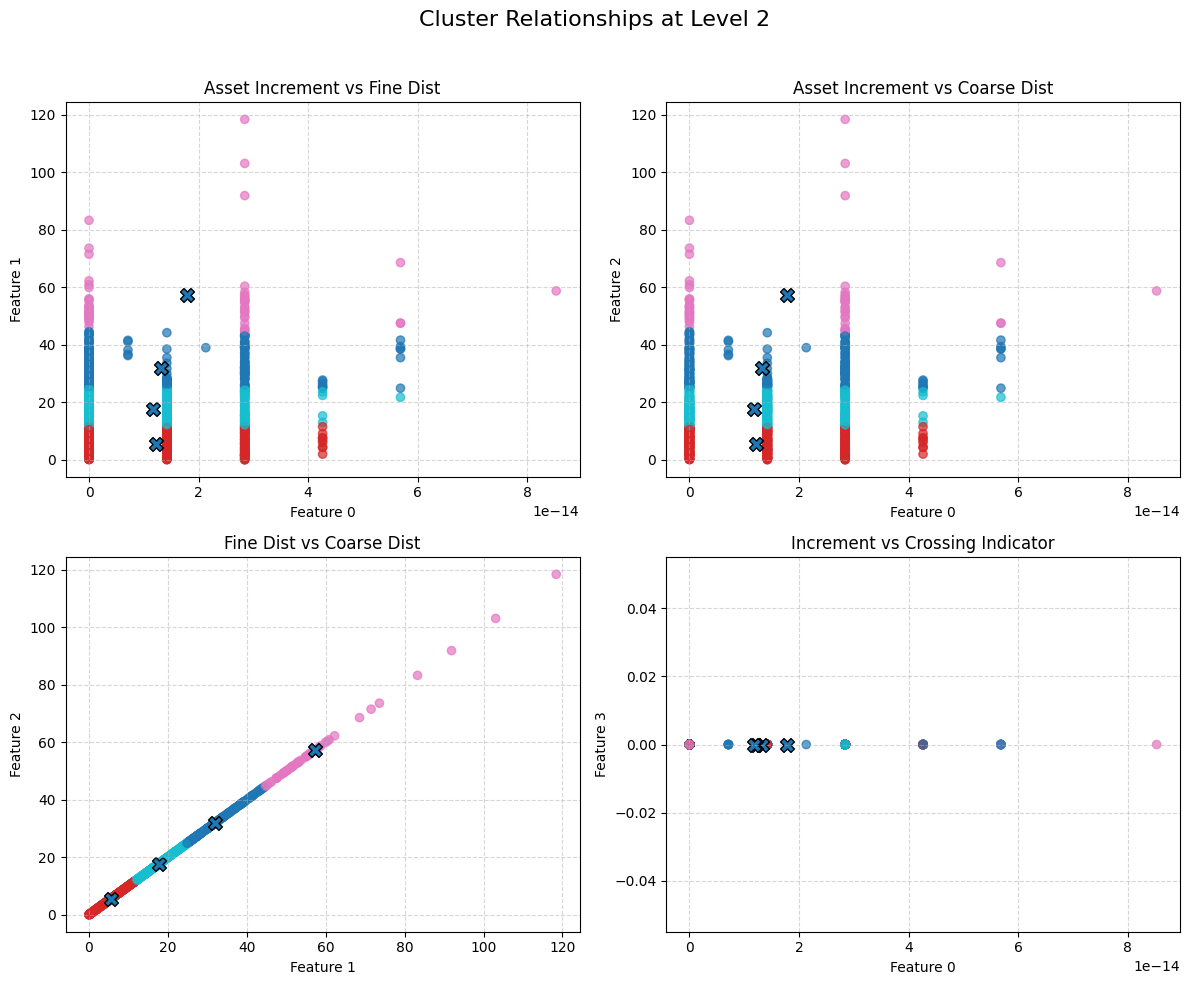

In [33]:
clusters_info = cmlmc.get_clusters()  # dict: level → {'model','features','labels'}
import matplotlib.pyplot as plt

for lvl, info in clusters_info.items():
    feats   = info['features']
    labs    = info['labels']
    centers = info['model'].cluster_centers_

    # 2×2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    # Define the four feature‐pairs and titles
    plot_defs = [
        (0, 1, 'Asset Increment vs Fine Dist'),
        (0, 2, 'Asset Increment vs Coarse Dist'),
        (1, 2, 'Fine Dist vs Coarse Dist'),
        (0, 3, 'Increment vs Crossing Indicator'),
    ]

    for ax, (i, j, title) in zip(axes, plot_defs):
        # scatter points colored by cluster
        sc = ax.scatter(feats[:, i], feats[:, j], c=labs, cmap='tab10', alpha=0.7)
        # overlay centroids
        ax.scatter(centers[:, i], centers[:, j], marker='X', s=100, edgecolors='k')
        ax.set_title(title)
        ax.set_xlabel(f'Feature {i}')
        ax.set_ylabel(f'Feature {j}')
        ax.grid(True, ls='--', alpha=0.5)

    fig.suptitle(f'Cluster Relationships at Level {lvl}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
